In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np; np.set_printoptions(precision=5,suppress=True)
np.random.seed(0)
import matplotlib.pyplot as plt
import pandas
import cvxpy as cvx
from plot_settings import savefig
import scipy

from extquadcontrol import ExtendedQuadratic, dp_finite
from system import FiniteHorizonSystem
from policy import Policy, AffinePolicy

In [3]:
life_table = pandas.read_csv('data/life_table.tsv', delimiter='\t',
                header=None,
                names=['age','M_deathprob','M_numlives','M_expectancy',\
                        'F_deathprob','F_numlives','F_expectancy']);

In [4]:
inflation = pandas.read_csv('data/inflation.csv', header=None)
inflation = np.array(inflation)
inflation = 1+.01*inflation[:80,1].astype(np.float32)

In [5]:
returns = 1 + .01*pandas.read_csv('data/returns.csv')
returns = returns[-80:]
sp = returns['sp']/inflation
tbill = returns['tbill']/inflation
tbond = returns['tbond']/inflation

In [6]:
X = np.log(np.c_[sp,tbill,tbond])
mu = np.mean(X, axis=0)
sigma = np.cov(X.T)
samp = np.exp(np.random.multivariate_normal(mu,sigma,size=100000))
samp[:10]

array([[0.80485, 0.95377, 0.98823],
       [0.74443, 0.98292, 0.86484],
       [0.91751, 1.0017 , 1.02455],
       [1.0033 , 0.95036, 1.0133 ],
       [0.94684, 0.98002, 1.00683],
       [1.01563, 0.97507, 0.89755],
       [1.01491, 1.10092, 1.06346],
       [0.96315, 1.00287, 0.93983],
       [0.73951, 1.01717, 1.13782],
       [1.1071 , 0.92636, 0.90698]])

In [7]:
mean = np.exp(mu + .5*np.diag(sigma))
covariance = np.diag(mean)@(np.exp(sigma)-np.ones((3,3)))@np.diag(mean)

In [8]:
mean

array([1.08538, 1.00053, 1.01686])

In [9]:
np.mean(samp, axis=0)

array([1.08571, 1.00039, 1.01643])

In [10]:
covariance

array([[0.0316 , 0.00077, 0.00003],
       [0.00077, 0.00142, 0.00139],
       [0.00003, 0.00139, 0.00673]])

In [11]:
np.cov(samp.T)

array([[0.03156, 0.00076, 0.00007],
       [0.00076, 0.00142, 0.00139],
       [0.00007, 0.00139, 0.00672]])

In [12]:
np.sqrt(np.diag(covariance))

array([0.17776, 0.03775, 0.08203])

In [13]:
np.std(samp, axis=0)

array([0.17765, 0.03768, 0.082  ])

In [14]:
max_consumption = 100
h_consumption = 1000.
a = 2*h_consumption/max_consumption**2
b = -2*h_consumption/max_consumption

max_bequest = 2000.
h_bequest = 10000.
a_bequest = 2*h_bequest/max_bequest**2
b_bequest = -2*h_bequest/max_bequest

In [15]:
a, b

(0.2, -20.0)

/home/shane/miniconda3/envs/gen_lqr/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


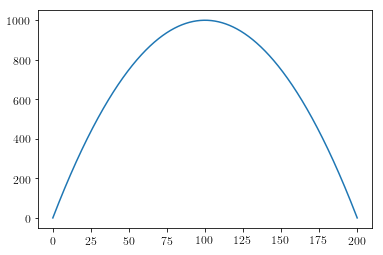

In [16]:
cons = np.linspace(0,200,1000)
plt.plot(cons, -.5*a*cons**2 - b*cons)
plt.show()

In [17]:
a_bequest, b_bequest

(0.005, -10.0)

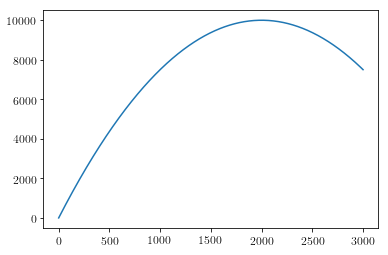

In [18]:
cons = np.linspace(0,3000,1000)
plt.plot(cons, -.5*a_bequest*cons**2 - b_bequest*cons)
plt.show()

In [19]:
n = 1
m = 3
N = 200
K = 2 # 0=alive, 1=deceased
T = 120

gamma = 1e-2

def sample(t,N):
    A = np.zeros((N,K,n,n))
    B = np.zeros((N,K,n,m))
    r = np.exp(np.random.multivariate_normal(mu,sigma,size=N))
    B[:,0,0,:] = r
    c = np.zeros((N,K,n))
        
    P1 = np.r_[
        np.c_[np.array([[a]]), -a*np.ones((1,m))],
        np.c_[-a*np.ones((m,1)), a*np.ones((m,m))+gamma*(covariance-0*np.ones((3,3)))]
    ]
    q1 = np.r_[np.array([b]),-b*np.ones(m)]
    r1 = 0
    g1 = ExtendedQuadratic(P1,q1,r1)
        
    F2 = np.c_[np.zeros((m,n)),np.eye(m)]
    g2 = np.zeros(m)
    P2 = np.r_[
        np.c_[np.array([[a_bequest]]),np.zeros((1,m))],
        np.c_[np.zeros((m,1)),np.zeros((m,m))]
    ]
    q2 = np.r_[np.array([b_bequest]),np.zeros(m)]
    r2 = 0
    g2 = ExtendedQuadratic(P2,q2,r2,F2,g2)
    
    g = [[g1,g2] for _ in range(N)]

    deathprob = life_table.M_deathprob[t]
    if t == 119:
        deathprob = 1.
    Pi = np.array([
        [1.-deathprob,0.],
        [deathprob,1.]
    ])
    
    return A,B,c,g,Pi

P_f = np.zeros((n,n))
q_f = np.zeros(n)
g_T = [ExtendedQuadratic(P_f,q_f,0) for _ in range(K)]

In [20]:
A,B,c,g,Pi=sample(0,1)

In [21]:
system = FiniteHorizonSystem(sample, g_T, K)
Vs, Qs, policies = dp_finite(sample, g_T, T, N)
policy = AffinePolicy(policies)

In [22]:
V = Vs[60][0]

In [23]:
V


P: [[0.00172]]
q: [-5.34913]
r: -43086.14373679517

 F: []
g: []

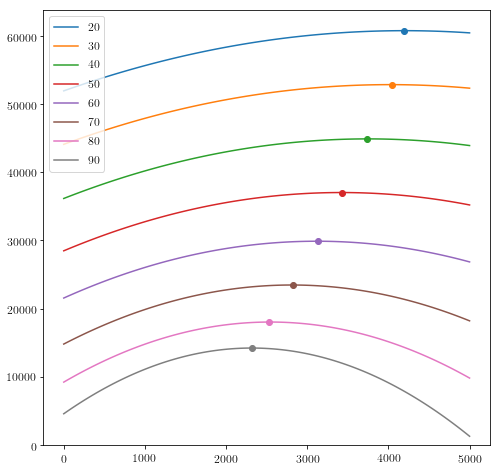

In [24]:
fig = plt.figure(figsize=(8,8))

for t in range(20,100,10):
    V = Vs[t][0]
    xs = np.linspace(0,5000,100)
    ys = [-V(np.array([x])).flatten()[0] for x in xs]

    plt.plot(xs, ys, label=str(t))
    i = np.argmax(ys)
    plt.scatter([xs[i]],[ys[i]])

plt.ylim(0)
plt.legend()
plt.savefig('figs/value.pdf')
plt.show()

In [25]:
fs, gs = [], []
ages = range(60,118)

for t in ages:
    Kp,kp = policies[t][0]
    f = 1-np.sum(Kp)
    g = -np.sum(kp)+2000*f
    
    fs.append(f)
    gs.append(g)

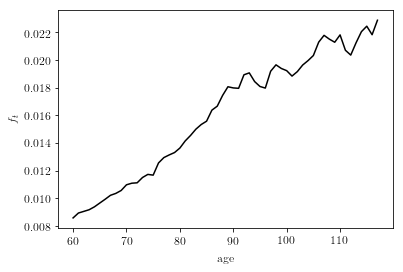

In [26]:
fig = plt.figure()
plt.plot(ages, fs, color='black')
plt.xlabel('age')
plt.ylabel('$f_t$')
savefig(fig, 'figs/f.pdf', width=6,height=4)
plt.show()

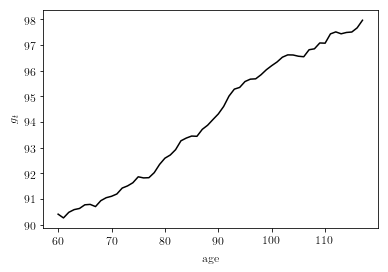

In [27]:
fig = plt.figure()
plt.plot(ages, gs, color='black')
plt.xlabel('age')
plt.ylabel('$g_t$')
savefig(fig, 'figs/g.pdf', width=6,height=4)
plt.show()

In [28]:
system.simulate?

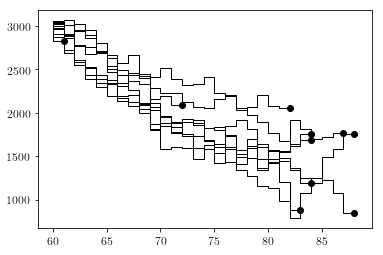

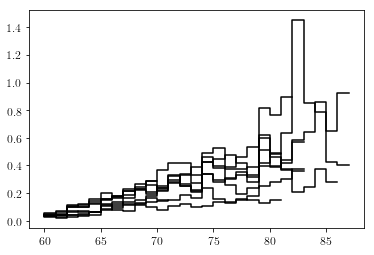

In [29]:
t0 = 60
fig, ax1 = plt.subplots()
fig1, ax2 = plt.subplots()
for _ in range(10):
    X, U, Modes, cost = system.simulate(np.array([3000]), 0, T, policy, 60)
    age = np.arange(t0,t0+Modes.index(1)+1)
    X = X[:Modes.index(1)+1]
    U = U[:Modes.index(1)+1]
    wealth = X.flatten()
    ax1.step(age, wealth, linewidth=1, color='black')
    ax1.scatter([age[-1]],[X[-1]], color='black')
    
    ax2.step(age[:-1], U[:-1,0]/wealth[:-1], color='black')

In [30]:
ax1.set_xlabel('age')
ax1.set_ylabel('wealth')
ax2.set_xlabel('age')
ax2.set_ylabel('fraction of wealth in sp')
savefig(fig, 'figs/wealth.pdf', width=6, height=4)
savefig(fig1, 'figs/risky.pdf', width=6, height=4)
plt.show()

In [31]:
t0 = 60
consumptions = np.nan*np.ones((500,120-60))
bequests = []
wealths = np.nan*np.ones((500,120-60))
for i in range(500):
    X, U, Modes, cost = system.simulate(np.array([3000]), 0, T, policy, t0)
    age = np.arange(t0,t0+Modes.index(1)+1)
    X = X[:Modes.index(1)+1]
    U = U[:Modes.index(1)+1]
    wealth = X.flatten()
    
    consumption = wealth[:-1] - np.sum(U[:-1], axis=1)
    consumptions[i,:len(consumption)] = consumption
    wealths[i,:len(wealth)] = wealth
    bequests.append(wealth[-1])

/home/shane/miniconda3/envs/gen_lqr/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


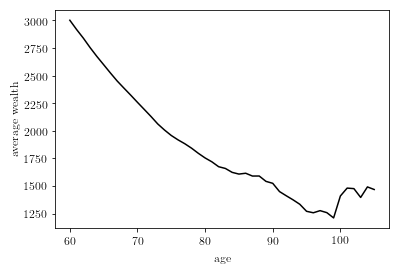

In [32]:
avg_wealth = np.nanmean(wealths, axis=0)
ind = np.where(np.isnan(avg_wealth))[0][0]

fig = plt.figure()
plt.plot(np.arange(60,60+ind), avg_wealth[:ind], c='black')
plt.xlabel('age')
plt.ylabel('average wealth')
savefig(fig, 'figs/avg_wealth.pdf', width=6,height=4)
plt.show()

/home/shane/miniconda3/envs/gen_lqr/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


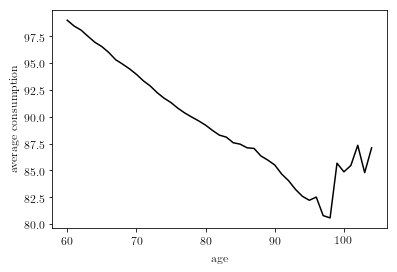

In [33]:
avg_consumption = np.nanmean(consumptions, axis=0)
ind = np.where(np.isnan(avg_consumption))[0][0]

fig = plt.figure()
plt.plot(np.arange(60,60+ind), avg_consumption[:ind], c='black')
plt.xlabel('age')
plt.ylabel('average consumption')
savefig(fig, 'figs/avg_con.pdf', width=6,height=4)
plt.show()

/home/shane/miniconda3/envs/gen_lqr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


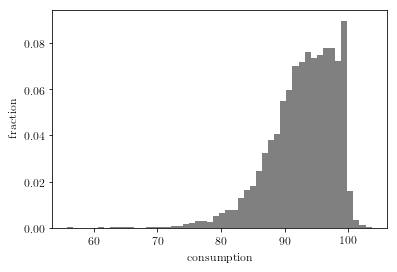

In [34]:
fig = plt.figure()
plt.hist(consumptions[~np.isnan(consumptions)].flatten(), bins=50, normed=1, color='gray')
plt.xlabel('consumption')
plt.ylabel('fraction')
savefig(fig, 'figs/consumption_hist.pdf', width=6, height=4)
plt.show()

/home/shane/miniconda3/envs/gen_lqr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


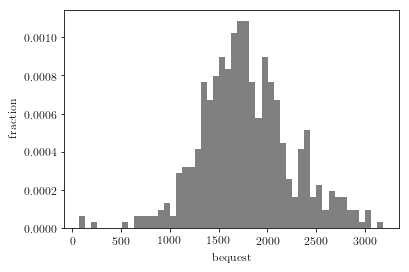

In [35]:
fig = plt.figure()
plt.hist(bequests, bins=50, normed=1, color='gray')
plt.xlabel('bequest')
plt.ylabel('fraction')
savefig(fig, 'figs/bequest_hist.pdf', width=6, height=4)
plt.show()

In [36]:
np.median(bequests)

1747.0533577348979